## 0.2.epoch调参分析

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

Global seed set to 0
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

1. 读取数据

In [3]:
adata_filename = "../gastrulation_bak/data/gastrulation.h5ad"

adata = scv.read(adata_filename)
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 20000 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

## 预处理

In [4]:
batch_pair_list = [
    ["E6.5", "E6.75"],
    ["E6.75", "E7.0"],
    ["E7.0", "E7.25"],
    ["E7.25", "E7.5"],
    ["E7.5", "E7.75"],
    ["E7.75", "E8.0"],
    ["E8.0", "E8.25"],
    ["E8.25", "E8.5"],
]
knn_mask, bnn_mask, subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key, batch_pair_list=batch_pair_list)

Filtered out 45080 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
calculating knn and bnn mask...
pair_list : [['E6.5', 'E6.75'], ['E6.75', 'E7.0'], ['E7.0', 'E7.25'], ['E7.25', 'E7.5'], ['E7.5', 'E7.75'], ['E7.75', 'E8.0'], ['E8.0', 'E8.25'], ['E8.25', 'E8.5']]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


smoothing...
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 断点训练

In [5]:
max_epochs = 500
sep = 100

# max_epochs = 100
# sep = 20

model_epoch_sep_savedir = "./model/epoch_parameter_adjustment/(%s,%s)"%(sep, max_epochs) # TODO: 这里保存路径以后需要更改
log_epoch_sep_save_dir = "./log/epoch_parameter_adjustment/(%s,%s)"%(sep, max_epochs)


epoch_list = range(0, max_epochs+1, sep)[1:] # TOOD: 数据量越大，查看的epoch间隔应该越小


# 每次断点指定模型训练的epoch
sep_epoch_list = [epoch_list[0]] 
for i in range(1, len(epoch_list)):
    sep_epoch_list.append(epoch_list[i]-epoch_list[i-1])
# sep_epoch_list.append(max_epochs-epoch_list[-1]) # 最后这个不保存
sep_epoch_list

[100, 100, 100, 100, 100]

In [6]:
from pytorch_lightning import loggers

velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
velovgi_model = velovgi.tl.VELOVGI(subsample_adata)

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    sep_epoch = sep_epoch_list[i] # 此次断点训练的epoch数目
    print(epoch, sep_epoch)
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    logger = loggers.TensorBoardLogger(save_dir=log_epoch_sep_save_dir, name=name) # 构造日志文件
    
    velovgi_model.train(max_epochs=sep_epoch, logger=logger, checkpoint_mode="checkpoint")
    velovgi_model.save("%s/%s"%(model_epoch_sep_savedir, name))# 模型保存

100 100
初始训练，初始化runner参数
choosing neighbor minibatch


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [32:51<00:00, 19.76s/it, loss=2.09e+04, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [32:51<00:00, 19.71s/it, loss=2.09e+04, v_num=1]
200 100
断点继续训练
断点的epochs： 100


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/(100,500)/200_epoch(max_epochs=500)


Epoch 100/100: 100%|██████████| 100/100 [32:54<00:00, 19.73s/it, loss=-5.9e+03, v_num=0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [32:54<00:00, 19.74s/it, loss=-5.9e+03, v_num=0]
300 100
断点继续训练
断点的epochs： 100


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/(100,500)/300_epoch(max_epochs=500)


Epoch 100/100: 100%|██████████| 100/100 [28:48<00:00, 16.20s/it, loss=-6.3e+03, v_num=0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [28:48<00:00, 17.28s/it, loss=-6.3e+03, v_num=0]
400 100
断点继续训练
断点的epochs： 100


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/(100,500)/400_epoch(max_epochs=500)


Epoch 100/100: 100%|██████████| 100/100 [27:06<00:00, 16.24s/it, loss=-6.38e+03, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [27:06<00:00, 16.27s/it, loss=-6.38e+03, v_num=0]
500 100
断点继续训练
断点的epochs： 100


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/(100,500)/500_epoch(max_epochs=500)


Epoch 100/100: 100%|██████████| 100/100 [22:56<00:00, 13.44s/it, loss=-6.38e+03, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [22:56<00:00, 13.77s/it, loss=-6.38e+03, v_num=0]


## 读取断点训练结果，看看整体和基因速率图

1. 读取断点训练结果

In [7]:
name_list =[]
adata_list = []

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    name_list.append(name)
    # 提取模型
    # model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=True)
    model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=False)
     # 输出结果
    velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, model)
    tmp_adata = adata.copy()
    velovgi.pp.moment_recover(tmp_adata, subsample_adata)
    adata_list.append(tmp_adata)
adata_list

INFO     File ./model/epoch_parameter_adjustment/(100,500)/100_epoch(max_epochs=500)/model.pt already downloaded   
INFO     File ./model/epoch_parameter_adjustment/(100,500)/200_epoch(max_epochs=500)/model.pt already downloaded   
INFO     File ./model/epoch_parameter_adjustment/(100,500)/300_epoch(max_epochs=500)/model.pt already downloaded   
INFO     File ./model/epoch_parameter_adjustment/(100,500)/400_epoch(max_epochs=500)/model.pt already downloaded   
INFO     File ./model/epoch_parameter_adjustment/(100,500)/500_epoch(max_epochs=500)/model.pt already downloaded   


[AnnData object with n_obs × n_vars = 20000 × 2000
     obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns: 'celltype_colors', 'neighbors', 'sample_recover'
     obsm: 'X_pca', 'X_umap'
     layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'fit_t'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 20000 × 2000
     obs: 'barcode', 'sample', 'st

2. 绘制整体速率图

100_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/20000 [00:00<?, ?cells/s]

    finished (0:01:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 10 regions of root cells and 3 regions of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


200_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/20000 [00:00<?, ?cells/s]

    finished (0:01:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 10 regions of root cells and 3 regions of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


300_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/20000 [00:00<?, ?cells/s]

    finished (0:01:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 9 regions of root cells and 3 regions of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


400_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/20000 [00:00<?, ?cells/s]

    finished (0:01:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 10 regions of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


500_epoch(max_epochs=500)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/20000 [00:00<?, ?cells/s]

    finished (0:00:50) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 10 regions of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


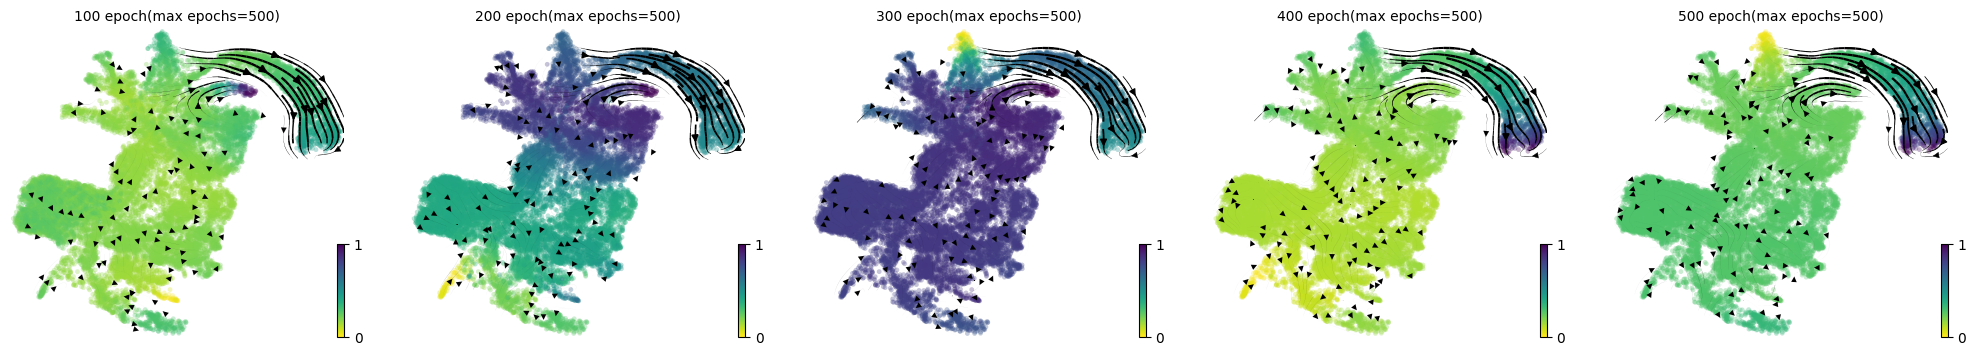

In [8]:
n = len(epoch_list)
fig, ax = velovgi.pl.calc_fig(n)
for i in range(n):
    print(name_list[i])
    name = name_list[i]
    tmp_adata = adata_list[i]
    scv.tl.velocity_graph(tmp_adata) # 转移矩阵计算
    scv.tl.velocity_pseudotime(tmp_adata) # 速率的伪时间计算
    scv.pl.velocity_embedding_stream(tmp_adata, color="velocity_pseudotime", ax=ax[i], title=name, show=False)

## 调参选择

目前这里看来，应该是到60左右最好。但实际最好还是看tensorborad的loss面板，发现实际对应的原本的50左右的epoch。